# Определение отношения между значениями индексов миролюбия и уровня образования в разных странах мира

автор: [Владимир Сизов](mailto:vladimirsizov@yandex.ru)

Кажется интуитивно очевидным предположение что в странах с более высоким уровнем образования общество более осознанно, более внимательно к окружающим и поэтому менее агрессивно по сравнению с странами обладающими низким уровнем образования.   

Стоит осторожно подходить к определению причин связи миролюбия и образования, в силу множества факторов влияющих на определения этих показателей таких как уровень благосостояния населения, климатические, географические, политические, экономические, исторические культурные и прочие факторы.

Глобальный индекс миролюбия (Global Peace Index) — это комплексный показатель, который характеризует миролюбие стран мира, измеряя уровень насилия внутри государства и уровень агрессивности его внешней политики. Также он оценивает возможные конфликты и в целом допустимость любого насилия в обществе. Рейтинг показывает, какие из государств можно считать наиболее безопасными (и наоборот — опасными) для жизни человека.
При итоговом расчёте Индекса, внутренним факторам (то есть вопросам, характеризующим миролюбие государства к своим гражданам и самих граждан друг к другу) уделяется больше внимания — вес этих оценок составляет 60%, а вес внешних факторов (то есть внешнеполитических критериев) составляет 40%.
[источник данных](https://nonews.co/directory/lists/countries/global-peace-index)

Индекс уровня образования в странах мира (Education Index) — комбинированный показатель Программы развития Организации Объединённых Наций (ПРООН), который измеряет достижения страны с точки зрения достигнутого уровня образования её населения.
[источник данных](https://gtmarket.ru/ratings/education-index)

<hr>

В этом ноутбуке с помощью метода линейной регрессии мы определим зависимость этих двух величин, посмотрим насколько хорошо модель описывает эти данные

In [379]:
import pandas as pd
import re
import numpy as np
import scipy
import pingouin as pg
import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid', rc={'figure.figsize': (12,6.75)})

In [380]:
# ожидаемая и средняя продолжительность обучения в годах
edu = pd.read_csv('education.csv', names=['country', 'exp_edu', 'fact_edu'])[['country', 'fact_edu']]
edu.head()

,country,fact_edu
0,Австра­лия,12.7
1,Новая Зелан­дия,12.9
2,Исландия,13.8
3,Швеция,12.6
4,Бельгия,12.4


In [381]:
# уровень миролюбия
pcf = pd.read_csv('peacefulness.csv', names=['country', 'peacful'])
pcf.head()

,country,peacful
0,Исландия,1.107
1,Новая Зеландия,1.269
2,Ирландия,1.288
3,Дания,1.296
4,Австрия,1.300


Немного подготовим данные для объёдинения

In [382]:
# переименуем дубли
rename_country = {"Кот-д'Ивуар": 'Кот-д’Ивуар',
                  'Буркина Фасо': 'Буркина-Фасо',
                  'Папуа — Новая Гвинея': 'Папуа - Новая Гвинея',
                  'ЦАР': 'Центрально-Африканская Республика',
                  'ЮАР': 'Южная Африка',
                  'ДР Конго': 'Демократическая Республика Конго',
                  'ОАЭ': 'Объединённые Арабские Эмираты',
                  'США': 'Соединённые Штаты Америки',}

In [383]:
# замена дублей
def rc(x):
    for k, v in rename_country.items():
        if x == k:
            return v
            break
    return x

In [384]:
# приведём названия стран к одинаковым значениям
pcf['country'] = pcf['country'].apply(lambda x: rc(x))
edu['country'] = edu['country'].apply(lambda x: re.sub(r'\xad', '', x))
edu['country'] = edu['country'].apply(lambda x: rc(x))

In [385]:
# объединим таблицы
data = edu.merge(pcf, on='country', how='inner')

In [386]:
data.describe()

,fact_edu,peacful
count,155.000000,155.000000
mean,8.876129,2.065200
std,3.342157,0.499581
min,2.100000,1.107000
25%,5.900000,1.768000
50%,9.200000,1.990000
75%,11.650000,2.324000
max,14.100000,3.554000


Индекс образовании fact_edu указан в годах от 2.1 до 14.1 лет. 

Значения ндекса миролюбия peacful от 1.107 до 3.554, что может быть не очень удобно для понимания оценки.  
Мы переведём эти значения в шкалу от 1 до 100, где 100 это самая миролюбивая страна, а 0 нет.

In [387]:
data['pcf_correct'] = data.peacful - data.peacful.min()
data['pcf_correct'] = 100 - (data.pcf_correct / data.pcf_correct.max() * 100)
data = data[['country', 'fact_edu', 'pcf_correct']]

,country,fact_edu,pcf_correct
140,Афганистан,3.0,0.000000
145,Йемен,3.2,6.538619
134,Сирия,5.1,8.091541
26,Россия,12.8,11.401716
150,Южный Судан,5.7,15.120556
...,...,...,...
31,Австрия,12.3,92.112791
6,Дания,13.0,92.276257
12,Ирландия,11.6,92.603188
1,Новая Зеландия,12.9,93.379649


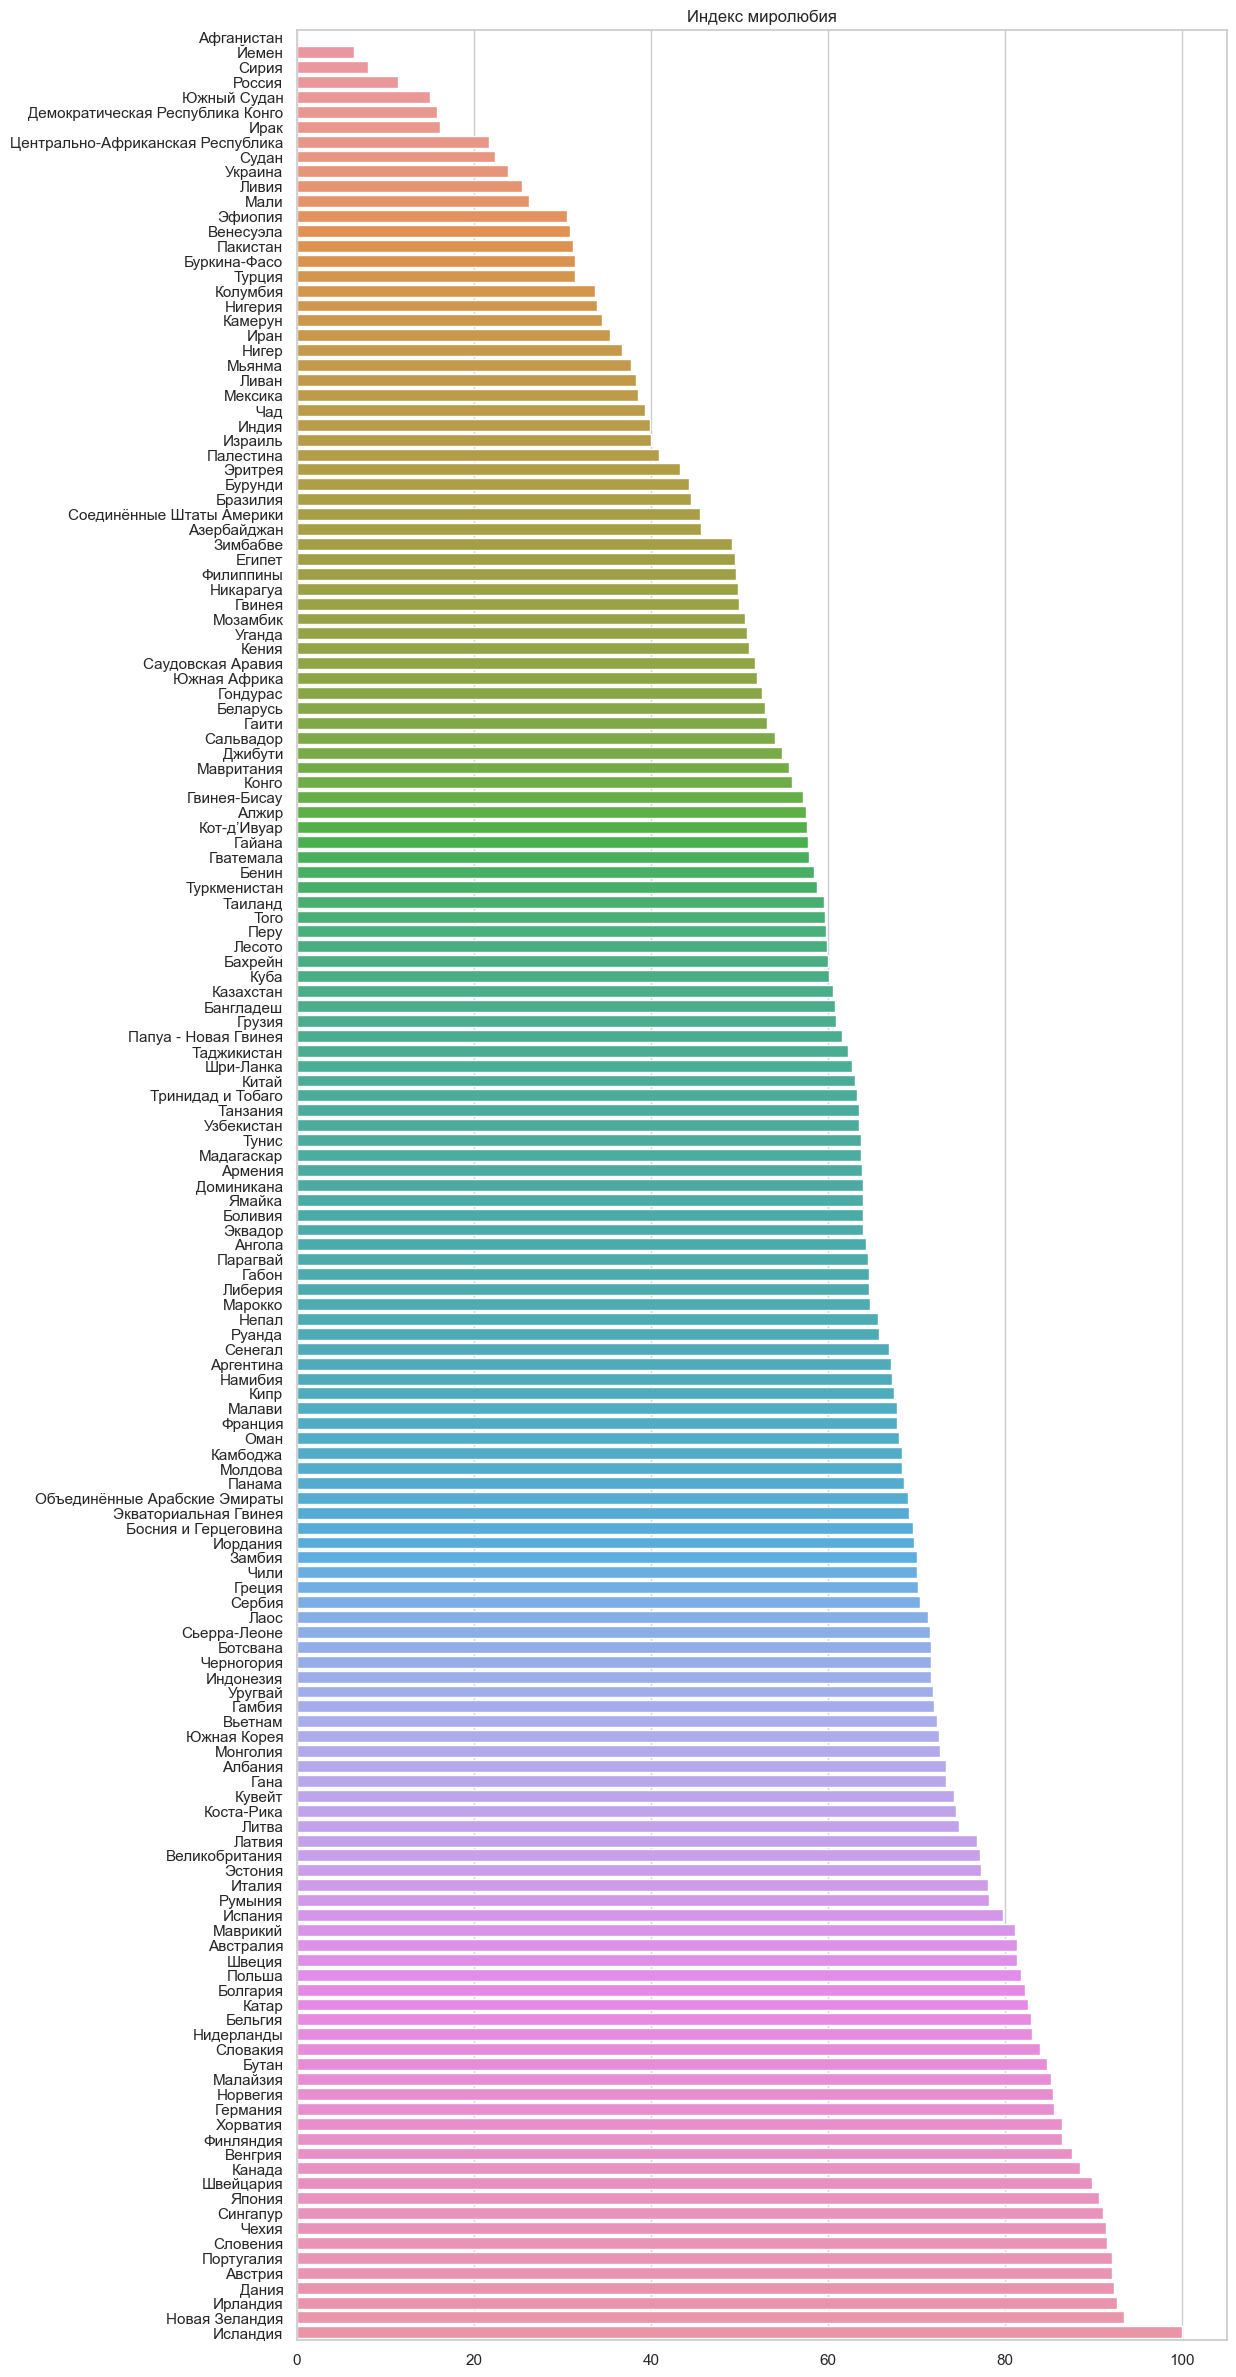

In [388]:
# индекс миролюбия
display(data.sort_values('pcf_correct'))
sns.set(style='whitegrid', rc={'figure.figsize': (12,30)})
sns.barplot(data=data.sort_values('pcf_correct'), x='pcf_correct', y='country') \
    .set(title='Индекс миролюбия', xlabel='', ylabel='');

,country,fact_edu,pcf_correct
154,Нигер,2.1,36.738864
151,Буркина-Фасо,2.1,31.385370
146,Гвинея,2.2,49.938700
153,Мали,2.3,26.277074
152,Чад,2.6,39.354311
...,...,...,...
16,Соединённые Штаты Америки,13.7,45.525133
2,Исландия,13.8,100.000000
15,Канада,13.8,88.475685
14,Швейцария,13.9,89.783408


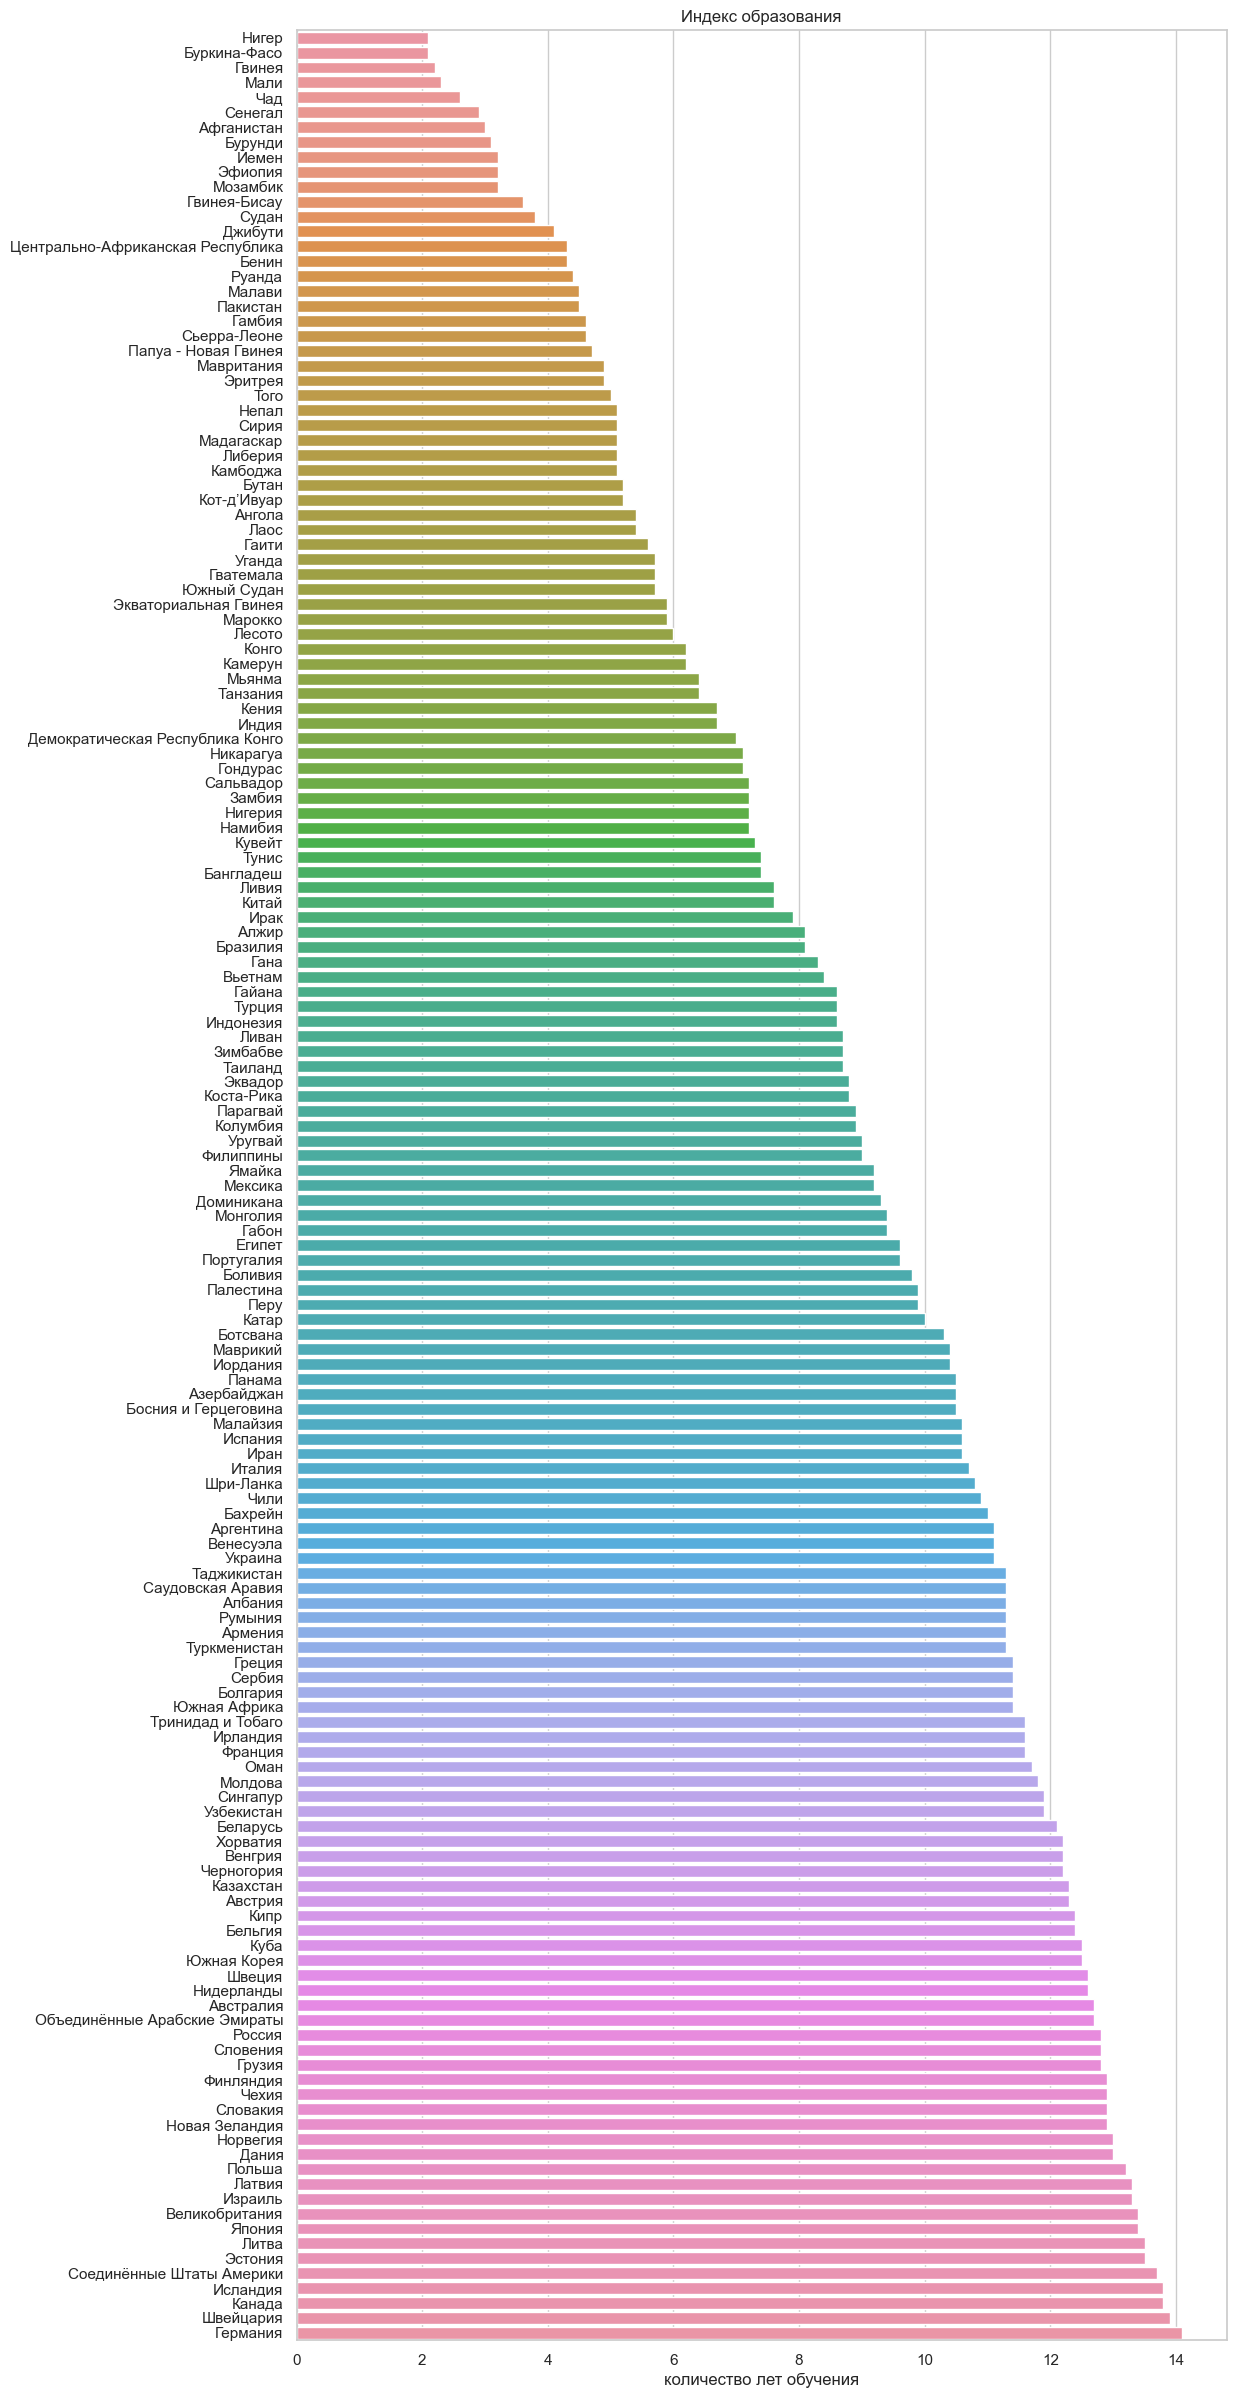

In [389]:
# график индекса образования
display(data.sort_values('fact_edu'))
sns.set(style='whitegrid', rc={'figure.figsize': (12,30)})
sns.barplot(data=data.sort_values('fact_edu'), x='fact_edu', y='country') \
    .set(title='Индекс образования', ylabel='', xlabel='количество лет обучения');

В этой модели мы рассмотрим как относится изменение рейтинга миролюбия относительно количества лет образования. 

In [390]:
# подготовим модель линейной регрессии
y = data['pcf_correct']
x = data['fact_edu']
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            pcf_correct   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     58.97
Date:                Fri, 12 May 2023   Prob (F-statistic):           1.77e-12
Time:                        23:55:46   Log-Likelihood:                -661.70
No. Observations:                 155   AIC:                             1327.
Df Residuals:                     153   BIC:                             1333.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.2427      3.978      8.106      0.0

R-squared: 0.278 28% часть дисперсии зависимой переменной обусловленная взаимосвязью с независимой 

pcf_correct/P>|t| 0.000 pvalue<0.05 сообщает о стат значимости результатов  

Durbin-Watson: 0.500 тест Дарбина-Ватсона на независимость остатков показывает что остатки скоррелированы, что может несколько ухудшить прогноз

const/coef 32.2427 уровень миролюбия 32% при отсутствии образования  

pcf_correct/coef 3.2220 с каждым годом образования уровень миролюбия населения увеличивается на 3.2

In [391]:
#уровень агрессии при отсутствии образования
b0 = 32.2427

# максимальный срок образования
b1 = data.fact_edu.min()
# расчётное уравнение регрессии
y = round(b0 + b1 * 3.2220)
print(f'В странах при среднем сроке образования {b1} лет, средний индекс миролюбия {y}')

# максимальный срок образования
b1 = data.fact_edu.max()
# расчётное уравнение регрессии
y = round(b0 + b1 * 3.2220)
print(f'В странах при среднем сроке образования {b1} лет, средний индекс миролюбия {y}')

В странах при среднем сроке образования 2.1 лет, средний индекс миролюбия 39
В странах при среднем сроке образования 14.1 лет, средний индекс миролюбия 78


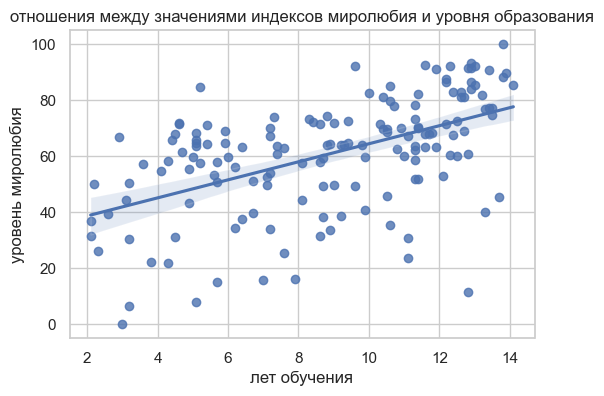

In [392]:
# посмотрим на график регрессии
sns.set(style='whitegrid', rc={'figure.figsize': (6, 4)})
sns.regplot(y=data.pcf_correct, x=data.fact_edu, ) \
    .set(title='отношения между значениями индексов миролюбия и уровня образования', \
         xlabel='лет обучения',  ylabel='уровень миролюбия');

Проверим предположения модели

eval_env: 1


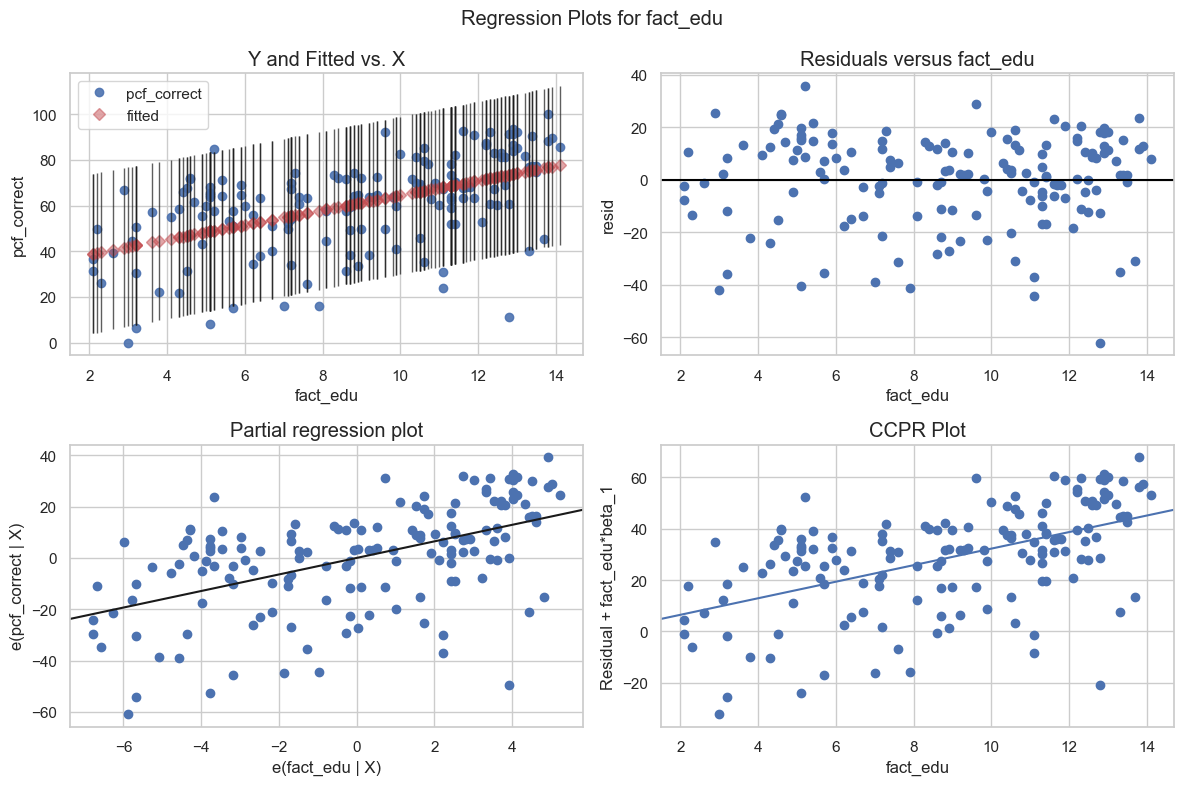

In [393]:
# Проверим на линейную связь между предиктором и переменной-отклика 
# График на котором сопоставленные значения отображаются с остаточными значениями 
fig = plt.figure(figsize=(12,8))
sm.graphics.plot_regress_exog(results, 'fact_edu', fig=fig);

На графике Residuals versus fact_edu остатки случайно разбросаны, что говорит о гомоскедаскичности остатков

In [394]:
# заодно проведём тест Бреуша-Пагана на гомоскедастичность остатков
lzip(['p-value'], sms.het_breuschpagan(results.resid, fit.model.exog))

[('p-value', 1.1151513940475688)]

p-value>0.05 H0 остатки гомоскедастичны

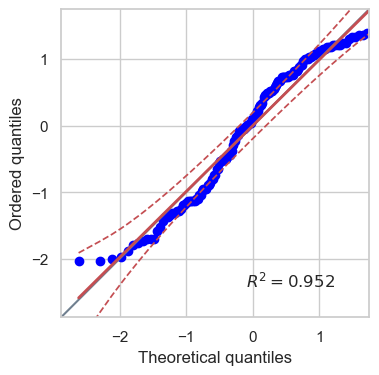

In [395]:
# Тест на нормальность остатков
pg.qqplot(data.fact_edu);

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

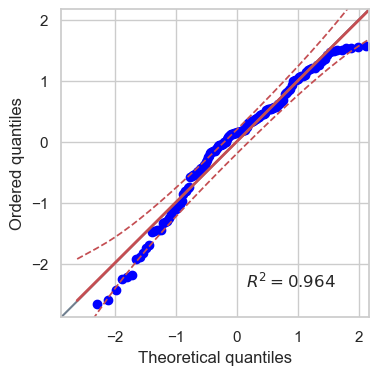

In [396]:
pg.qqplot(data.pcf_correct)

In [397]:
# проверим имеют ли данные соответствие нормальному распределению.
scipy.stats.anderson(data.fact_edu)

AndersonResult(statistic=2.5604662922543753, critical_values=array([0.562, 0.64 , 0.768, 0.896, 1.066]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=8.876129032258065, scale=3.342156622950737)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

поскольку critical_values=0.768 для α=0.05 не превышает допустимое statistic=2.56 значит H0 данные распределены нормально

In [398]:
scipy.stats.anderson(data.pcf_correct)

AndersonResult(statistic=1.731834472542971, critical_values=array([0.562, 0.64 , 0.768, 0.896, 1.066]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=60.841847159787484, scale=20.41604554647349)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

поскольку critical_values=0.768 для α=0.05 не превышает допустимое statistic=1.73 значит H0 данные распределены нормально

In [407]:
# определим качество предсказания для каждой страны
data['rating_model'] = data.fact_edu.apply(lambda x: 32.2427 + x * 3.2220)
data['diff'] = abs(data.pcf_correct - data.rating_model)
data['diff'] = data['diff'].max() - data['diff']
data['diff'] = data['diff'] / data['diff'].max() * 100
data = data.sort_values('diff')
data

,country,fact_edu,pcf_correct,rating_model,diff
26,Россия,12.8,11.401716,73.4843,0.000000
50,Украина,11.1,23.825092,68.0069,28.843151
140,Афганистан,3.0,0.000000,41.9087,32.505763
100,Ирак,7.9,16.223948,57.6965,33.208519
134,Сирия,5.1,8.091541,48.6749,34.641257
...,...,...,...,...,...
63,Таиланд,8.7,59.501430,60.2741,98.787402
122,Уганда,5.7,50.878627,50.6081,99.596495
62,Боливия,9.8,63.955864,63.8183,99.810734
42,Черногория,12.2,71.638741,71.5511,99.891174


,country,fact_edu,pcf_correct,rating_model,diff
26,Россия,12.8,11.401716,73.4843,0.000000
50,Украина,11.1,23.825092,68.0069,28.843151
140,Афганистан,3.0,0.000000,41.9087,32.505763
100,Ирак,7.9,16.223948,57.6965,33.208519
134,Сирия,5.1,8.091541,48.6749,34.641257
...,...,...,...,...,...
63,Таиланд,8.7,59.501430,60.2741,98.787402
122,Уганда,5.7,50.878627,50.6081,99.596495
62,Боливия,9.8,63.955864,63.8183,99.810734
42,Черногория,12.2,71.638741,71.5511,99.891174


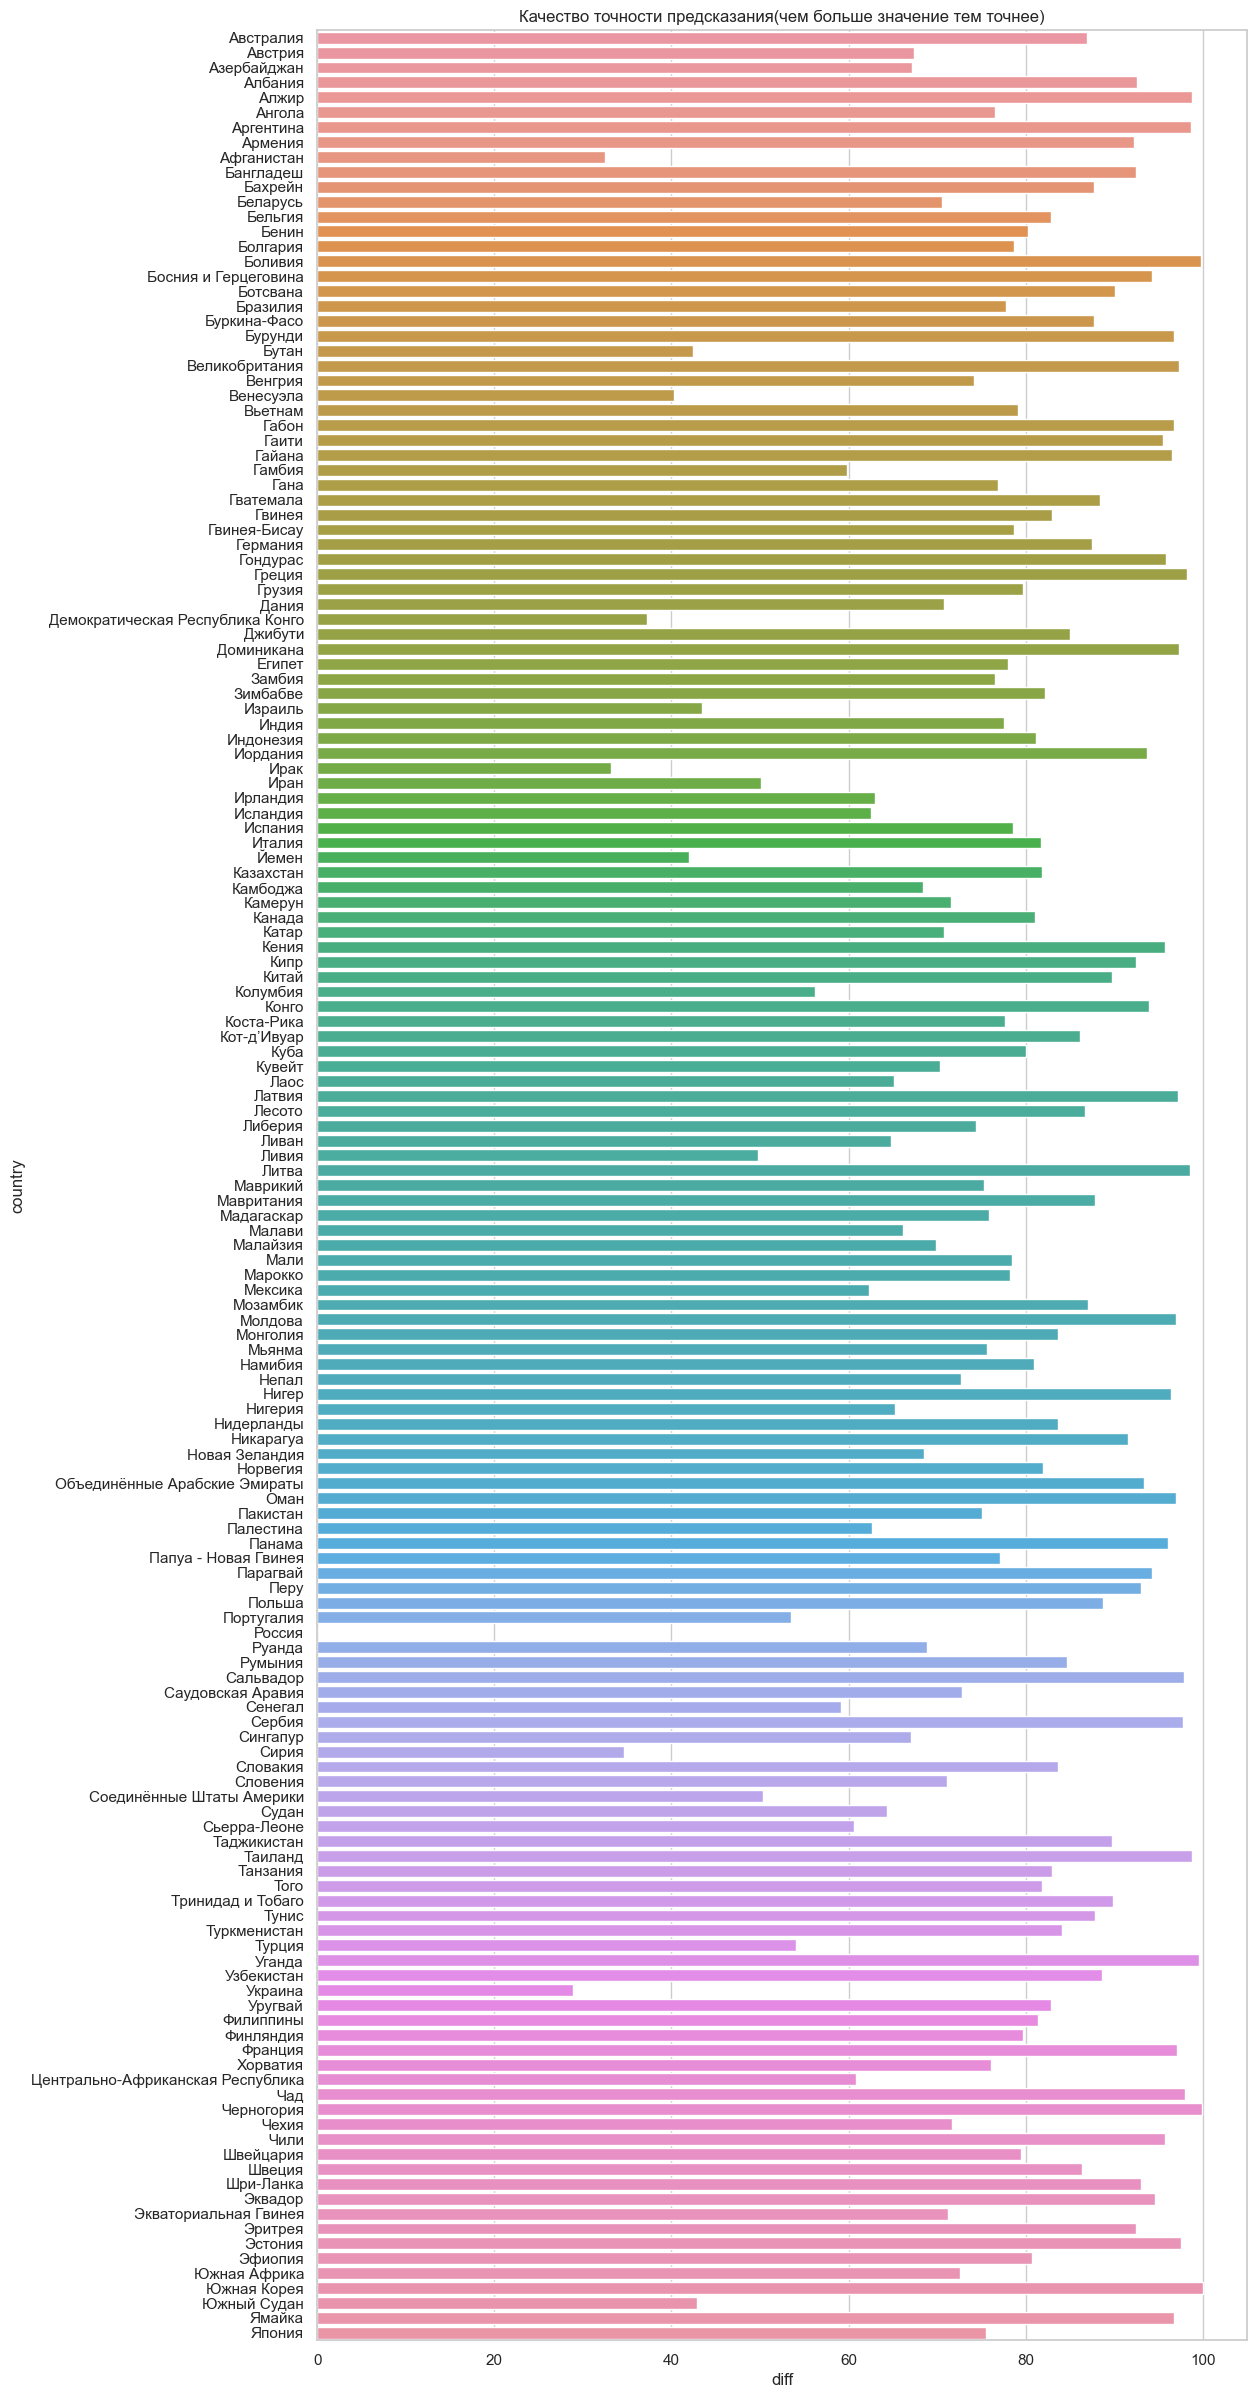

In [408]:
# построим график стран наиболее точно описаных моделью
display(data.sort_values('diff'))
sns.set(style='whitegrid', rc={'figure.figsize': (12,30)})
sns.barplot(data=data.sort_values('country'), x='diff', y='country') \
    .set(title='Качество точности предсказания(чем больше значение тем точнее)');

In [409]:
data[data.country == 'Россия']

,country,fact_edu,pcf_correct,rating_model,diff
26,Россия,12.8,11.401716,73.4843,0.0


<hr>

## Вывод:
28% значений описывает связь между значениями индексов
тесты подтверждают стат значимость результатов, хотя с некоторым ухудшением прогноза из-за скоррелированности остатков

В среднем можно утверждать что между странами с самым маленьким сроком образования 2.1 год и самым большим 14.1 год разница в миролюбии различается в два раза от 39 до 78 пунктов из 100

Каждый дополнительный год образования увеличивает индекс миролюбия на 3.2 пункта